# 서울시 생활정보 기반 대중교통 수요 분석 (1)

### 목표
* 생활정보를 분석하여 버스 정류장 또는 노선의 신설이 필요한 곳을 탐색

### 데이터
* 1 구별 버스 통계 데이터
* 2 행정구 인구 이동 데이터
* 3 주민등록인구 데이터
* 4 사업체분포 데이터
---

In [1]:
# 분석
import pandas as pd
import numpy as np
import scipy.stats as spst
import openpyxl # pd.read_excel

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rc("font", family="Malgun Gothic")
sns.set_theme(font="Malgun Gothic", 
              rc={"axes.unicode_minus":False}, style='white')

## 1A> 버스 승하차 인원 데이터
|구분||
|-|-|
|파일명|**(1) BUS_STATION_BOARDING_MONTH_202204.csv**|
|출처|https://data.seoul.go.kr/dataList/OA-12912/S/1/datasetView.do|
|설명|서울시 버스노선별 정류장별 승하차 인원 정보 (2022년 4월)|

In [3]:
bus_io = pd.read_csv('./data/(1) BUS_STATION_BOARDING_MONTH_202204.csv', encoding='cp949')
bus_io.head(2)

,사용일자,노선번호,노선명,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자
0,20220401,2112,2112번(면목동~성북동),06243,장안동삼성쉐르빌아파트,31,156,20220404
1,20220401,2112,2112번(면목동~성북동),06242,새서울병원,46,153,20220404


### 1A-1> 데이터 전처리
* 버스정류장ARS번호 앞 2자리 = 구 코드
* 25번까지만 서울이므로 그 외 지역 및 가상기점/종점 제외

In [4]:
# pd.options.display.float_format = '{:.2f}'.format # 지수 표현식 제거
# pd.reset_option('display.float_format') # reset
ars_num = bus_io.loc[~bus_io['버스정류장ARS번호'].str.contains('N|~')]['버스정류장ARS번호'].astype(int)
print("버스정류장ARS번호 범위: %d ~ %d" % (ars_num.min(), ars_num.max()))

버스정류장ARS번호 범위: 1001 ~ 68237


In [5]:
bus_io['지역구'] = bus_io['버스정류장ARS번호'].str.slice(0, 2).map({
    '01':'종로구',  '02':'중구',    '03':'용산구',    '04':'성동구',  '05':'광진구',
    '06':'동대문구',    '07':'중랑구',  '08':'성북구',  '09':'강북구',  '10':'도봉구',
    '11':'노원구',  '12':'은평구',  '13':'서대문구',  '14':'마포구',    '15':'양천구',
    '16':'강서구',  '17':'구로구',  '18':'금천구',  '19':'영등포구',    '20':'동작구',
    '21':'관악구',  '22':'서초구',  '23':'강남구',  '24':'송파구',  '25':'강동구'
})

In [6]:
print(bus_io.isna().sum())
bus_io.dropna(axis=0, inplace=True)
bus_io.drop(columns='등록일자', axis=1, inplace=True)

bus_io.rename(columns={'버스정류장ARS번호':'ARS_ID'}, inplace=True)
bus_io['ARS_ID'] = bus_io['ARS_ID'].astype(int)


사용일자               0
노선번호               0
노선명                0
버스정류장ARS번호         0
역명                 0
승차총승객수             0
하차총승객수             0
등록일자               0
지역구           105284
dtype: int64


In [7]:
bus_io.loc[(bus_io['지역구'] == '동대문구') & (bus_io['ARS_ID'] == 6001)]

,사용일자,노선번호,노선명,ARS_ID,역명,승차총승객수,하차총승객수,지역구
8329,20220401,9403,9403번(성남분당~을지로5가),6001,답십리역사거리,7,24,동대문구
11736,20220401,721,721번(북가좌동~건대입구역),6001,답십리역사거리,439,262,동대문구
22971,20220401,130,130번(우이동~길동),6001,답십리역사거리,546,219,동대문구
34695,20220401,N30,N30(강동공영차고지~서울역환승센터),6001,답십리역사거리,11,8,동대문구
36620,20220401,370,370번(강동공영차고지~충정로역),6001,답십리역사거리,490,253,동대문구
...,...,...,...,...,...,...,...,...
1142069,20220430,721,721번(북가좌동~건대입구역),6001,답십리역사거리,281,232,동대문구
1142934,20220430,9403,9403번(성남분당~을지로5가),6001,답십리역사거리,4,25,동대문구
1145549,20220430,370,370번(강동공영차고지~충정로역),6001,답십리역사거리,449,206,동대문구
1150866,20220430,N30,N30(강동공영차고지~서울역환승센터),6001,답십리역사거리,11,14,동대문구


In [8]:
# bus_io.loc[bus_io['지역구'] == '동대문구'].groupby('ARS_ID', as_index=False).size()

In [9]:
sns.set_palette('coolwarm', bus_io['지역구'].nunique())

### 1A-2> 데이터 이해

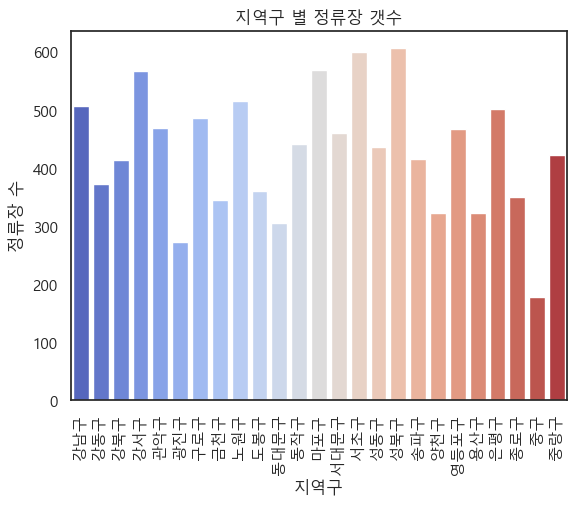

In [10]:
sns.barplot(x='지역구', y='ARS_ID',
            data=bus_io.groupby('지역구', as_index=False)['ARS_ID'].nunique().sort_values(by='지역구'),
            hue='지역구', legend=False, palette=sns.color_palette())
plt.xticks(rotation=90)
plt.ylabel('정류장 수')
plt.title('지역구 별 정류장 갯수')
plt.show()

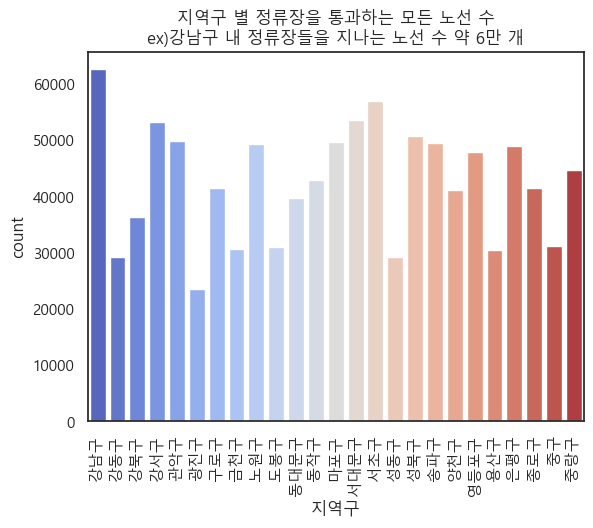

In [11]:
sns.barplot(x='지역구', y='size',
            data=bus_io.groupby('지역구', as_index=False)['ARS_ID'].size().sort_values(by='지역구'),
            hue='지역구', legend=False, palette=sns.color_palette())
plt.xticks(rotation=90)
plt.ylabel('count')
plt.title('지역구 별 정류장을 통과하는 모든 노선 수\nex)강남구 내 정류장들을 지나는 노선 수 약 6만 개')
plt.show()

## 1B> 버스 정류소 데이터

|구분||
|-|-|
|파일명|**(2) 서울시버스정류소위치정보(20230613).xlsx**|
|출처|https://data.seoul.go.kr/dataList/OA-15067/S/1/datasetView.do|
|설명|서울시 버스정류장 위치정보(2023년 6월)|

In [10]:
station = pd.read_excel('./data/(2) 서울시버스정류소위치정보(20230613).xlsx')
station.head(2)

,NODE_ID,ARS_ID,정류소명,X좌표,Y좌표
0,100000001,1001,종로2가사거리,126.987750,37.569765
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183


### 1B-1> 데이터 전처리

In [11]:
station.drop(columns='NODE_ID', axis=1, inplace=True)

## 1A+1B> 구별 버스 통계 데이터

In [12]:
seoul_bus = pd.merge(left=bus_io, right=station, how='inner', on='ARS_ID').sort_values(by='사용일자').reset_index(drop=True)
seoul_bus.head()

,사용일자,노선번호,노선명,ARS_ID,역명,승차총승객수,하차총승객수,지역구,정류소명,X좌표,Y좌표
0,20220401,105,105번(상계동~서울역),6018,청량리역환승센터,226,181,동대문구,청량리역환승센터,127.045668,37.580372
1,20220401,N15,N15번(사당역~우이동),21101,서울미술고.인헌중고,2,2,관악구,서울미술고.인헌중고,126.965554,37.476466
2,20220401,601,601번(개화동~종로4가),13014,세브란스병원앞,117,251,서대문구,세브란스병원앞,126.938451,37.559967
3,20220401,2222,2222번(자양동~고대앞),4574,성동구청,161,86,성동구,성동구청,127.036423,37.563956
4,20220401,N15,N15번(사당역~우이동),20114,노량진역,3,3,동작구,노량진역3번출구,126.941757,37.513391


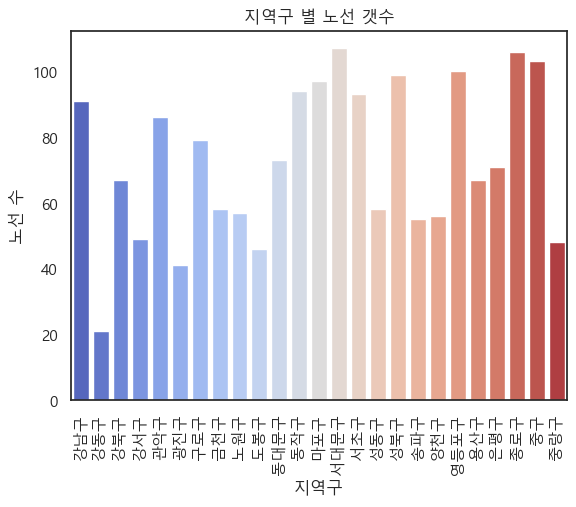

In [13]:
sns.barplot(x='지역구', y='노선번호',
            data=seoul_bus.groupby('지역구', as_index=False)['노선번호'].nunique().sort_values(by='지역구'),
            hue='지역구', legend=False, palette=sns.color_palette())
plt.xticks(rotation=90)
plt.ylabel('노선 수')
plt.title('지역구 별 노선 갯수')
plt.show()

In [14]:
local_st = seoul_bus.groupby('지역구', as_index=False)['ARS_ID'].nunique().sort_values(by='지역구')
local_route = seoul_bus.groupby('지역구', as_index=False)['노선번호'].nunique().sort_values(by='지역구')
local_sum = seoul_bus.groupby('지역구', as_index=False)[['승차총승객수', '하차총승객수']].sum().sort_values(by='지역구')
local_mean = seoul_bus.groupby('지역구', as_index=False)[['승차총승객수', '하차총승객수']].mean().sort_values(by='지역구').round(1) # 정류장별 평균

local1 = pd.merge(local_st, local_route, how='inner', on='지역구')
local2 = pd.merge(local_sum, local_mean, how='inner', on='지역구')
local_bus = pd.merge(local1, local2, how='inner', on='지역구')

local_bus.rename(columns={'ARS_ID':'정류장수',
                          '노선번호':'노선수',
                          '승차총승객수_x':'총승차승객수',
                          '하차총승객수_x':'총하차승객수',
                          '승차총승객수_y':'평균승차승객수',
                          '하차총승객수_y':'평균하차승객수'}, inplace=True)

local_bus.head()

,지역구,정류장수,노선수,총승차승객수,총하차승객수,평균승차승객수,평균하차승객수
0,강남구,499,91,8030483,7569213,128.8,121.4
1,강동구,373,21,2894675,2840350,98.8,97.0
2,강북구,413,67,4825181,4671783,133.0,128.8
3,강서구,566,49,4681083,4652828,88.1,87.6
4,관악구,466,86,7655819,7792476,154.8,157.5


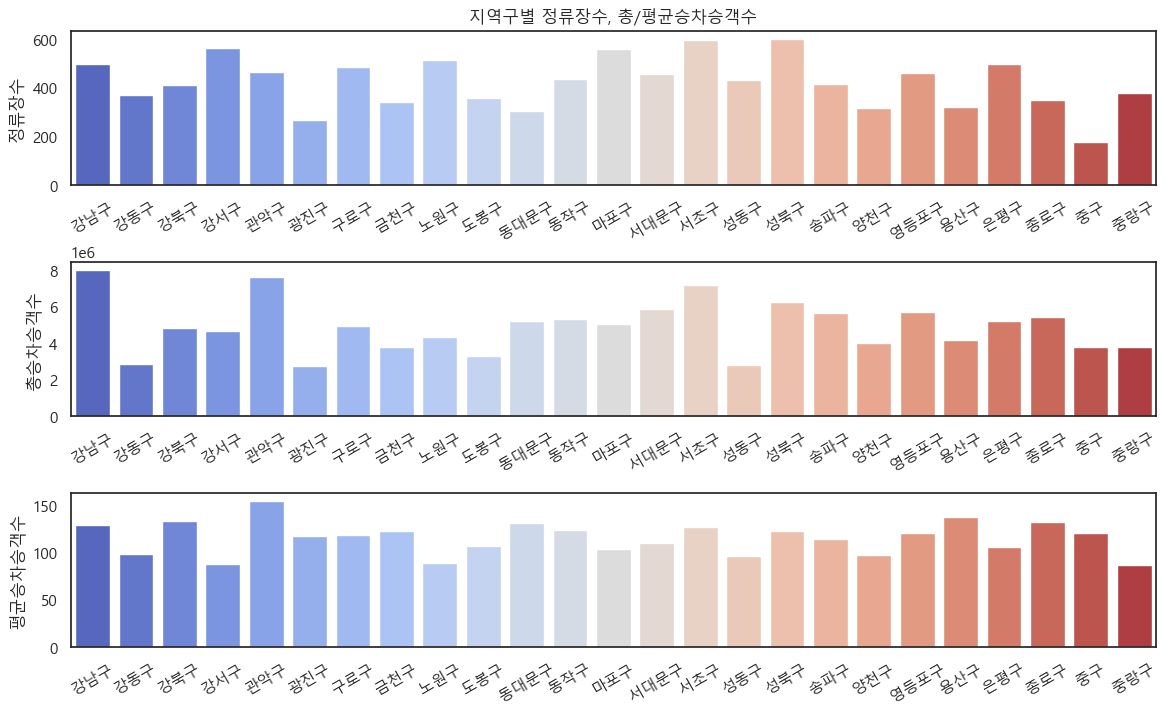

In [18]:
plt.figure(figsize=(14,8))
plt.subplots_adjust(hspace=0.5)

plt.subplot(3,1,1)
sns.barplot(x='지역구', y='정류장수', data=local_bus,
            hue='지역구', legend=False, palette=sns.color_palette())
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('정류장수')
plt.title("지역구별 정류장수, 총/평균승차승객수")

plt.subplot(3,1,2)
sns.barplot(x='지역구', y='총승차승객수', data=local_bus,
            hue='지역구', legend=False, palette=sns.color_palette())
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('총승차승객수')

plt.subplot(3,1,3)
sns.barplot(x='지역구', y='평균승차승객수', data=local_bus,
            hue='지역구', legend=False, palette=sns.color_palette())
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('평균승차승객수')

plt.show()

In [18]:
# local_bus.to_csv('dataA.csv', index=False)

## 2A> 인구 이동 데이터
|구분||
|-|-|
|파일명|**(3) 생활이동_자치구_2022.04_00시.csv ~ 생활이동_자치구_2022.04_23시.csv**|
|출처|https://data.seoul.go.kr/dataVisual/seoul/seoulLivingMigration.do|
|설명|서울시 생활이동 인구 데이터 (2022년 4월 0시~23시 통합)|
||이동 유형은 H(야간상주지), W(주간상주지), E(기타 지역)를 의미<br>예) HW : 야간상주지에서 주간상주지로 이동|

*  해석  
22년 4월 일요일에  
종로구(11010) 기타 지역(E)에서 종로구(11010) 기타 지역(E)으로 이동한  
0~10세 여성은 평균 10분 이동하여 0~0:59 사이에 도착했고  
총 28.02명이다.

In [19]:
path3_a = './data/(3) 생활이동_자치구_202204/생활이동_자치구_2022.04_'
path3_b = ['0' + str(x) for x in range(0, 10)] + [str(x) for x in range(10, 24)]
path3_c = '시.csv'

In [20]:
isFirst = True
for pb in path3_b:
    path3 = path3_a + pb + path3_c
    if isFirst:
        moving = pd.read_csv(path3, encoding='cp949')
        isFirst = False
    else:
        mv = pd.read_csv(path3, encoding='cp949')
        moving = pd.concat([moving, mv], axis=0, ignore_index=True)

moving.head()

,대상연월,요일,도착시간,출발 시군구 코드,도착 시군구 코드,성별,나이,이동유형,평균 이동 시간(분),이동인구(합)
0,202204,일,0,11010,11010,F,0,EE,10,28.02
1,202204,일,0,11010,11010,F,0,EH,10,27.52
2,202204,일,0,11010,11010,F,0,HE,10,27.83
3,202204,일,0,11010,11010,F,10,HW,10,6.05
4,202204,일,0,11010,11010,F,10,EH,90,5.95


In [21]:
moving.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28923054 entries, 0 to 28923053
Data columns (total 10 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   대상연월         int64 
 1   요일           object
 2   도착시간         int64 
 3   출발 시군구 코드    int64 
 4   도착 시군구 코드    int64 
 5   성별           object
 6   나이           int64 
 7   이동유형         object
 8   평균 이동 시간(분)  int64 
 9   이동인구(합)      object
dtypes: int64(6), object(4)
memory usage: 2.2+ GB


### 2A-1> 데이터 전처리

* 이동인구(합) column이 개인정보 비식별화를 위해 3명 미만의 경우 *로 처리되어 있다.

In [24]:
moving['이동인구(합)'].value_counts().to_frame()

,이동인구(합)
*,3842041
3.3,399374
6.05,366830
3.29,289731
3.31,232069
...,...
2352.37,1
1617.99,1
3141.86,1
1485.54,1


In [25]:
moving.loc[moving['이동인구(합)'] == '*', '이동인구(합)'] = 1.5 # 1명과 2명의 중앙값
moving['이동인구(합)'] = moving['이동인구(합)'].astype(float)

* 출입이 서울시 이외인 데이터 제거

In [61]:
moving = moving.loc[(moving['출발 시군구 코드'] < 20000) & (moving['도착 시군구 코드'] < 20000)]
moving.head()

,대상연월,요일,도착시간,출발 시군구 코드,도착 시군구 코드,성별,나이,이동유형,평균 이동 시간(분),이동인구(합)
0,202204,일,0,11010,11010,F,0,EE,10,28.02
1,202204,일,0,11010,11010,F,0,EH,10,27.52
2,202204,일,0,11010,11010,F,0,HE,10,27.83
3,202204,일,0,11010,11010,F,10,HW,10,6.05
4,202204,일,0,11010,11010,F,10,EH,90,5.95


## 2B> SGIS 행정구역코드
|구분||
|-|-|
|파일명|**(4) adm_code.xls**|
|출처|https://sgis.kostat.go.kr/view/newhelp/dd_help_20_0|
|설명|통계청의 행정구역코드(2022년 6월)|
||행정안전부와 통계청의 코드가 다름. ex)종로구 11110<->11010)|

In [68]:
seoul_code = pd.read_excel('./data/(4) adm_code.xls', sheet_name='2022년6월', header=1, dtype={'시도코드':str, '시군구코드':str})
seoul_code.head()

,시도코드,시도명칭,시군구코드,시군구명칭,읍면동코드,읍면동명칭
0,11,서울특별시,010,종로구,530,사직동
1,11,서울특별시,010,종로구,540,삼청동
2,11,서울특별시,010,종로구,550,부암동
3,11,서울특별시,010,종로구,560,평창동
4,11,서울특별시,010,종로구,570,무악동


### 2B-1> 데이터 전처리

In [69]:
seoul_code = seoul_code.drop(columns=['읍면동코드', '읍면동명칭'], axis=1).drop_duplicates()
seoul_code = seoul_code.loc[seoul_code['시도명칭'] == '서울특별시'].drop(columns='시도명칭', axis=1).rename(columns={'시군구코드':'bcode'})
seoul_code['시군구코드'] = (seoul_code['시도코드'] + seoul_code['bcode']).astype(int)
seoul_code = seoul_code.loc[:, ['시군구명칭', '시군구코드']].sort_values(by='시군구명칭').reset_index(drop=True)
seoul_code.head()

,시군구명칭,시군구코드
0,강남구,11230
1,강동구,11250
2,강북구,11090
3,강서구,11160
4,관악구,11210


## 2A+2B > 행정구 인구 이동 데이터

In [78]:
seoul_moving = pd.merge(moving, seoul_code, left_on='출발 시군구 코드', right_on='시군구코드', how='inner')
seoul_moving = seoul_moving.rename(columns={'시군구명칭':'출발시군구'}).drop(columns=['출발 시군구 코드', '시군구코드'], axis=1)
seoul_moving = pd.merge(seoul_moving, seoul_code, left_on='도착 시군구 코드', right_on='시군구코드', how='inner')
seoul_moving = seoul_moving.rename(columns={'시군구명칭':'도착시군구'}).drop(columns=['도착 시군구 코드', '시군구코드'], axis=1)
seoul_moving.head()

,대상연월,요일,도착시간,성별,나이,이동유형,평균 이동 시간(분),이동인구(합),출발시군구,도착시군구
0,202204,일,0,F,0,EE,10,28.02,종로구,종로구
1,202204,일,0,F,0,EH,10,27.52,종로구,종로구
2,202204,일,0,F,0,HE,10,27.83,종로구,종로구
3,202204,일,0,F,10,HW,10,6.05,종로구,종로구
4,202204,일,0,F,10,EH,90,5.95,종로구,종로구


In [79]:
# seoul_moving.to_csv('dataB.csv', index=False)

## 3> 서울시 주민등록인구 (구별) 통계
|구분||
|-|-|
|파일명|**(5) 주민등록인구_20230318121731.csv**|
|출처|https://data.seoul.go.kr/dataList/419/S/2/datasetView.do|
|설명|한국인(65세미만), 등록외국인, 65세이상고령자의 성별 통계(2022년 1분기)|
||세대: (=가족) 혈연, 혼인, 입양 등으로 한 집안을 이룬 사람들의 집단<br>가구: 혈연관계와는 상관없이 주거와 생계를 같이 하는 단위|

In [81]:
gu_people = pd.read_csv('data/(5) 주민등록인구_20230318121731.csv', header=1)
gu_people.head()

,동별(1),동별(2),세대 (세대),계 (명),계 (명).1,계 (명).2,한국인 (명),한국인 (명).1,한국인 (명).2,등록외국인 (명),등록외국인 (명).1,등록외국인 (명).2,세대당인구 (명),65세이상고령자 (명)
0,동별(1),동별(2),소계,소계,남자,여자,소계,남자,여자,소계,남자,여자,소계,소계
1,합계,소계,4451444,9732617,4716704,5015913,9506778,4613910,4892868,225839,102794,123045,2.14,1628980
2,합계,종로구,73766,153684,74018,79666,144275,69911,74364,9409,4107,5302,1.96,28064
3,합계,중구,63767,131450,63869,67581,122173,59448,62725,9277,4421,4856,1.92,24742
4,합계,용산구,111207,236518,114571,121947,222169,106735,115434,14349,7836,6513,2.00,39461


### 3-1> 데이터 전처리

* 컬럼 이름 변경

In [82]:
gu_people.drop(columns='동별(1)', axis=1, inplace=True)

new_cols = ['지역구', '세대수(세대)', '총계', '총 남자', '총 여자', '총 한국인', '한국인 남', '한국인 여', '총 외국인', '외국인 남', '외국인 여', '세대당인구', '65세이상']
gu_people.columns = new_cols
gu_people = gu_people.drop([0, 1]).reset_index(drop=True).sort_values(by='지역구', ignore_index=True)

* 컬럼 순서 변경
* 데이터타입 변경 (데이터 통계 방식에 유의)
    - 세대당인구 = 총 한국인/세대수(세대)
    - 총계 = 총 한국인 + 총 외국인 (65세이상 미포함)

In [83]:
new_cols2 = ['지역구', '세대당인구', '세대수(세대)', '총 한국인', '한국인 남', '한국인 여', '총 외국인', '외국인 남', '외국인 여', '총계', '총 남자', '총 여자', '65세이상']
gu_people = gu_people[new_cols2]

gu_people['세대당인구'] = gu_people['세대당인구'].astype(float)
for intcol in new_cols2[2:]:
    gu_people[intcol] = gu_people[intcol].astype(int)
gu_people.head()

,지역구,세대당인구,세대수(세대),총 한국인,한국인 남,한국인 여,총 외국인,외국인 남,외국인 여,총계,총 남자,총 여자,65세이상
0,강남구,2.27,234612,532577,254866,277711,4761,2230,2531,537338,257096,280242,79575
1,강동구,2.28,201926,461300,226203,235097,3797,1688,2109,465097,227891,237206,75477
2,강북구,2.05,144725,297384,144643,152741,3440,1291,2149,300824,145934,154890,64961
3,강서구,2.10,272572,573046,275422,297624,5380,2375,3005,578426,277797,300629,93924
4,관악구,1.74,279353,486375,244409,241966,13961,6041,7920,500336,250450,249886,80686


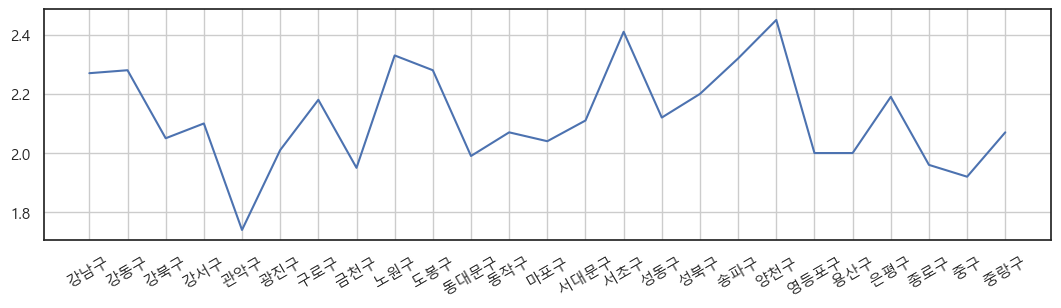

In [86]:
plt.figure(figsize=(13, 3))
plt.plot('지역구','세대당인구', data=gu_people)
plt.grid()
plt.xticks(rotation=30)
plt.show()

In [87]:
# gu_people.to_csv('dataC.csv', index=False)

## 4> 서울시 사업체분포 (다수업종/동별) 통계
|구분||
|-|-|
|파일명|**(6) 사업체분포(다수업종_동별)(2017년+이후)_20230318152531.csv**|
|출처|https://data.seoul.go.kr/dataList/10590/S/2/datasetView.do|
|설명|상위 10개 업종의 동별 사업체 수 및 종사자 수(2021년)|

In [29]:
business0 = pd.read_csv('data/(6) 사업체분포(다수업종_동별)(2017년+이후)_20230318152531.csv')
business0.head()

,동별(1),동별(2),동별(3),2021,2021.1,2021.2,2021.3,2021.4,2021.5,2021.6,...,2021.10,2021.11,2021.12,2021.13,2021.14,2021.15,2021.16,2021.17,2021.18,2021.19
0,동별(1),동별(2),동별(3),택시운송업,택시운송업,한식 일반 음식점업,한식 일반 음식점업,용달 화물자동차 운송업,용달 화물자동차 운송업,부동산 중개 및 대리업,...,커피전문점,커피전문점,기타 주점업,기타 주점업,남녀용 겉옷 및 셔츠 도매업,남녀용 겉옷 및 셔츠 도매업,일반 교과 학원,일반 교과 학원,한식 육류요리 전문점,한식 육류요리 전문점
1,동별(1),동별(2),동별(3),사업체수 (개),종사자수 (명),사업체수 (개),종사자수 (명),사업체수 (개),종사자수 (명),사업체수 (개),...,사업체수 (개),종사자수 (명),사업체수 (개),종사자수 (명),사업체수 (개),종사자수 (명),사업체수 (개),종사자수 (명),사업체수 (개),종사자수 (명)
2,합계,소계,소계,42360,65212,30899,82152,36870,37147,28161,...,19200,56685,13056,22017,14604,45288,15026,54362,10693,35052
3,합계,종로구,소계,187,187,1568,4600,671,671,605,...,1027,3286,576,1069,509,1038,139,416,405,1546
4,합계,종로구,사직동,8,8,241,804,33,33,67,...,151,523,84,168,8,38,9,36,50,198


In [30]:
new_colsA = business0.iloc[0].replace({'한식 일반 음식점업':'일반한식점',
                                       '용달 화물자동차 운송업':'화물운송업',
                                       '부동산 중개 및 대리업':'부동산업',
                                       '남녀용 겉옷 및 셔츠 도매업':'의류업',
                                       '일반 교과 학원':'학원',
                                       '한식 육류요리 전문점':'한식육류전문'})
new_colsB = business0.iloc[1].replace({'사업체수 (개)':'사업체갯수',
                                       '종사자수 (명)':'종사자수'})
new_cols4 = new_colsA + ' ' + new_colsB
new_cols4

동별(1)       동별(1) 동별(1)
동별(2)       동별(2) 동별(2)
동별(3)       동별(3) 동별(3)
2021        택시운송업 사업체갯수
2021.1       택시운송업 종사자수
2021.2      일반한식점 사업체갯수
2021.3       일반한식점 종사자수
2021.4      화물운송업 사업체갯수
2021.5       화물운송업 종사자수
2021.6       부동산업 사업체갯수
2021.7        부동산업 종사자수
2021.8      두발미용업 사업체갯수
2021.9       두발미용업 종사자수
2021.10     커피전문점 사업체갯수
2021.11      커피전문점 종사자수
2021.12    기타 주점업 사업체갯수
2021.13     기타 주점업 종사자수
2021.14       의류업 사업체갯수
2021.15        의류업 종사자수
2021.16        학원 사업체갯수
2021.17         학원 종사자수
2021.18    한식육류전문 사업체갯수
2021.19     한식육류전문 종사자수
dtype: object

In [32]:
business1 = business0.loc[(business0['동별(3)'] == '소계') & (business0['동별(2)'] != '소계')]
business1.columns = new_cols4
business1 = business1.drop(columns=[business1.columns[0], business1.columns[2]], axis=1)
business1 = business1.rename(columns={business1.columns[0]:'지역구'})

business = business1.sort_values(by='지역구').reset_index(drop=True)
business.head()

,지역구,택시운송업 사업체갯수,택시운송업 종사자수,일반한식점 사업체갯수,일반한식점 종사자수,화물운송업 사업체갯수,화물운송업 종사자수,부동산업 사업체갯수,부동산업 종사자수,두발미용업 사업체갯수,...,커피전문점 사업체갯수,커피전문점 종사자수,기타 주점업 사업체갯수,기타 주점업 종사자수,의류업 사업체갯수,의류업 종사자수,학원 사업체갯수,학원 종사자수,한식육류전문 사업체갯수,한식육류전문 종사자수
0,강남구,1036,1668,2749,9666,1013,1017,3251,7080,1406,...,1789,6265,825,1819,589,9515,1859,11244,822,4145
1,강동구,2580,3836,1150,2759,1677,1677,1324,1651,933,...,686,1787,538,794,110,1317,827,2728,419,1144
2,강북구,1578,2245,1017,2192,988,988,641,810,680,...,443,1095,542,796,57,104,300,754,333,949
3,강서구,3679,6180,1430,3801,2827,2853,1548,2454,1072,...,906,2728,754,1184,118,749,846,2303,594,1812
4,관악구,2059,2653,1327,3068,1648,1656,1112,1817,898,...,702,1952,624,1107,75,276,452,1422,425,1315


In [49]:
business.to_csv('dataD.csv', index=False)

In [ ]:
business[['지역구'] + [x for x in business.columns if '사업체' in x]]

## =

In [ ]:
# local_bus = pd.read_csv('dataA.csv')
# seoul_moving = pd.read_csv('dataB.csv')
# gu_people = pd.read_csv('dataC.csv')
# business = pd.read_csv('dataD.csv')